In [60]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [9]:
download.file("https://archive.ics.uci.edu/static/public/46/hepatitis.zip", "hepatitis_data.zip")

In [10]:
unzip("hepatitis_data.zip", "hepatitis.data")

In [97]:
c_names = c("class", "age" , "sex", "steroid", "antivirals", "fatigue", "malaise", "anorexia", "liver big", "liver firm", "spleen palpable", "spiders", "ascites", "varices", "bilirubin", "alk_phosphate", "sgot", "albumin", "protime", "histology")
hepatitis_data <- read_csv("hepatitis.data", col_names = c_names) 
hepatitis_data 



Rows: 155 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (15): steroid, fatigue, malaise, anorexia, liver big, liver firm, spleen...
dbl  (5): class, age, sex, antivirals, histology

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver big,liver firm,spleen palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,61,1,1,2,1,1,2,1,1,2,1,2,2,0.80,75,20,4.1,?,2
2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2
1,43,1,2,2,1,2,2,2,2,1,1,1,2,1.20,100,19,3.1,42,2


From this data-set the variable we are trying to predict is the Class.

This variable gives 1 if the patient died from hepatitis and 2 if they lived considering the given factors.
We are using it as a numerical value instead of categorical for the model in order to use linear regression instead of categorical. this way allowing us to predict a survival rate with the predictors.

The exploratory analysis however is done using class as a factor in order to make plot visualization easier since all values are arbitrarily 1 or 2.


In order to analyze this data-set with k nearest neighbors we will avoid the binary variables and use only the attributes with continuous values.

In [98]:
hepatitis_data_clean <- hepatitis_data |>
    select(class, age, bilirubin, alk_phosphate, sgot, albumin, protime) |>
    mutate_if(is.character, as.numeric)
hepatitis_data_clean
    

Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `bilirubin = .Primitive("as.double")(bilirubin)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


class,age,bilirubin,alk_phosphate,sgot,albumin,protime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,30,1.0,85,18,4.0,NA
2,50,0.9,135,42,3.5,NA
2,78,0.7,96,32,4.0,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,61,0.8,75,20,4.1,NA
2,53,1.5,81,19,4.1,48
1,43,1.2,100,19,3.1,42


With this our data is clean and ready to start with our exploratory analysis

We can have a simple summary, allowing us to understand how the data is spread out among each variable.

In [55]:
summary(hepatitis_data_2)

 class        age         bilirubin     alk_phosphate         sgot       
 1: 32   Min.   : 7.0   Min.   :0.300   Min.   : 26.00   Min.   : 14.00  
 2:123   1st Qu.:32.0   1st Qu.:0.700   1st Qu.: 74.25   1st Qu.: 31.50  
         Median :39.0   Median :1.000   Median : 85.00   Median : 58.00  
         Mean   :41.2   Mean   :1.428   Mean   :105.33   Mean   : 85.89  
         3rd Qu.:50.0   3rd Qu.:1.500   3rd Qu.:132.25   3rd Qu.:100.50  
         Max.   :78.0   Max.   :8.000   Max.   :295.00   Max.   :648.00  
                        NA's   :6       NA's   :29       NA's   :4       
    albumin         protime      
 Min.   :2.100   Min.   :  0.00  
 1st Qu.:3.400   1st Qu.: 46.00  
 Median :4.000   Median : 61.00  
 Mean   :3.817   Mean   : 61.85  
 3rd Qu.:4.200   3rd Qu.: 76.25  
 Max.   :6.400   Max.   :100.00  
 NA's   :16      NA's   :67      

With this we can have a glance at simple information on each variable, such as how many empty values and the amount of people who died and who survived 

The next step we can do with our exploratory data analysis is create a table showing the means of each of our predicted when grouped by the "Class". Allowing us to glance at some expectations of how the predictors differ in each case.

In [157]:
hepatitis_data_clean |> group_by(class) |>
summarise(across(age:protime, mean, na.rm = TRUE))

class,age,bilirubin,alk_phosphate,sgot,albumin,protime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,46.59375,2.543333,122.3750,99.83333,3.151852,43.50000
2,39.79675,1.146218,101.3137,82.43802,3.977679,66.57143


Now we can start looking at visualizing the data, firstly we will do a histogram showing the spread of the values of the Sgot test on each individual.
This is the amount of the protein serum glutamic-oxaloacetic transaminase found in their blood in units per liter. Using this type of plot we can visualize the influence a single predictor with the death rate.

Warning message:
“Removed 4 rows containing non-finite values (`stat_bin()`).”


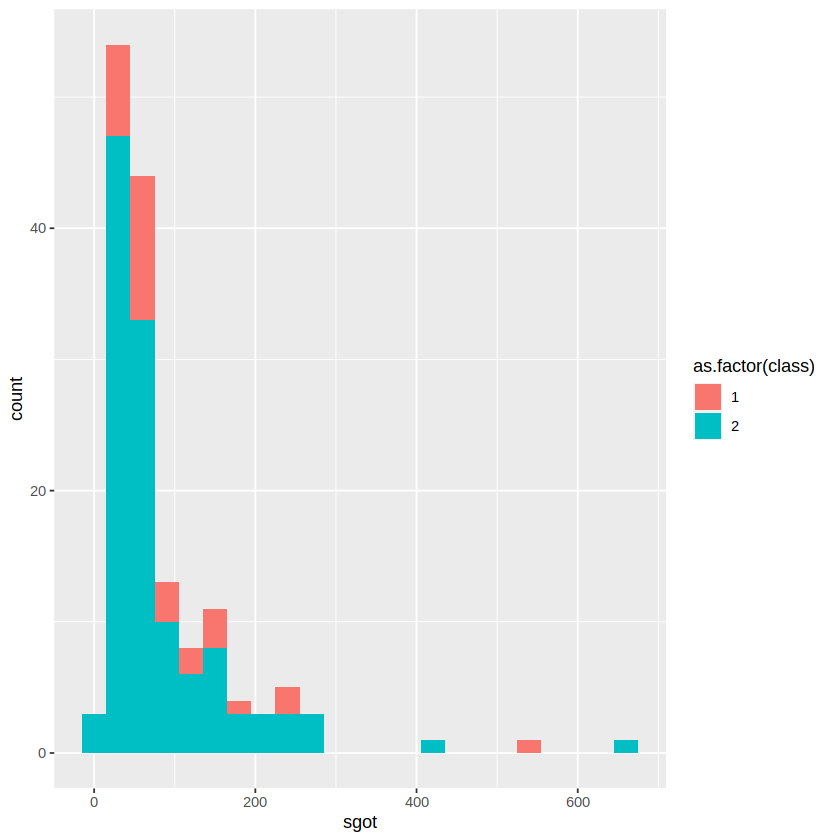

In [150]:
plot_1 <- hepatitis_data_clean |>
    ggplot(aes(x = sgot, fill = as.factor(class)),) +
    geom_histogram(binwidth = 30)
plot_1

Through this plot we can already see some correlations of death rates to a specific level of SGOT in their blood, however we should continue to explore the data, and one way to do so is with a scatterplot with two of our predictors colored by the Class variable.

This allows us to not only better understand the data we are dealing with by visualizing it's spread, it allows a glance at potential direct relationships for our K-nearest-neighbors model

Warning message:
“Removed 71 rows containing missing values (`geom_point()`).”


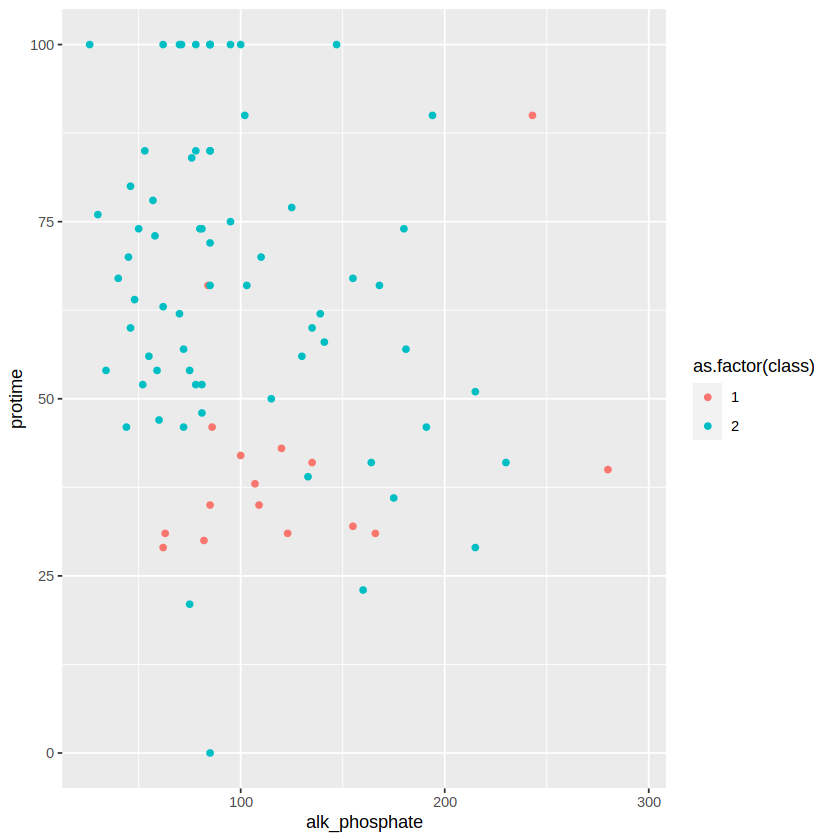

In [153]:
plot_1 <- hepatitis_data_clean |>
    ggplot(aes(x = alk_phosphate, y = protime, color = as.factor(class))) +
    geom_point()
plot_1

As we could see, this plot already shows a simple correlation of those two variables and the death rate, as there is clearly an area in which most deaths are grouped.

class,bilirubin,alk_phosphate,sgot,albumin,protime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.0,280,528,4.2,90
2,4.6,295,648,6.4,100
